**Table of contents**<a id='toc0_'></a>    
- [Define read and save path and load data](#toc1_)    
- [Set configs](#toc2_)    
- [How to handle big chunk missing data](#toc3_)    
  - [Select time span first and then impute data](#toc3_1_)    
  - [Impute data first then select time span](#toc3_2_)    
  - [Remove data has big missing chunks](#toc3_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import os
import random
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from matplotlib.colors import to_hex
from importlib import reload

import sys
if Path('/content/drive/MyDrive').exists():
  sys.path.append('/content/drive/MyDrive/Colab Notebooks/custom_modules')
else:
  sys.path.append('../custom_modules')
import TSClustering
reload(TSClustering)
from TSClustering import TSClustering

# <a id='toc1_'></a>[Define read and save path and load data](#toc0_)

In [2]:
base_path = Path('../../data_preprocessed')
save_dir = Path('../../Results_impute_analysis_test1')
if save_dir.exists() == False:
  save_dir.mkdir(parents=True, exist_ok=True)

read_processed_dir = base_path / '1. merged_peds_data_hist_curr'
read_raw_dir = Path('./Data (20230918)')

In [3]:
data = pd.read_csv(read_processed_dir / 'footfall_merged.csv') # the data should be unpivoted
data.rename(columns={'New_Sensor_Name': 'Sensor_Name'}, inplace=True)

# <a id='toc2_'></a>[Set configs](#toc0_)

In [4]:
model_configs = {
  # "metric": 'dtw',
  "random_state": 42
}

configs = {
  "data": data.copy(),
  "target_column": 'Sensor_Name', # target (sensor name)
  "time_column": 'Date_Time', # feature names (timestamp)
  "value_column": 'Hourly_Counts', # value
  "sensor_locations": data[['Sensor_Name', 'Latitude', 'Longitude', 'Location']],
  "save_dir": save_dir,
  "algorithm": 'kmeans',
  "scale": 'week', 
  "order_of_impute_agg_norm": "impute_agg_norm", 
  "time_span": 2019, 
  "feature_extraction": None, 
  "dim_reduction": "PCA", 
  "normalise": "meanvariance", 
  # "model_configs": model_configs, 
  "seed": 42,
  "verbose": False
}

In [5]:
pipeline = TSClustering(**configs)

the model's configs are set as default values.


In [6]:
data = data.pivot(index=configs["target_column"], columns=configs["time_column"], values=configs["value_column"])
data.columns = pd.to_datetime(data.columns)

# <a id='toc3_'></a>[How to handle big chunk missing data](#toc0_)

## <a id='toc3_1_'></a>[Select time span first and then impute data](#toc0_)

In [7]:
%%capture
save_dir = Path('../../Results_impute_analysis_test1')
pipeline.set_save_dir(save_dir) # set save dir
pipeline.root_save_dir = save_dir

data19 = pipeline.select_time_span(data)
pipeline.plot_data(data=data19, fig_name='plot_raw_data')

data19_imputed = pipeline.impute_data(data19)
pipeline.plot_data(fig_name='plot_imputed_data')

data19_agg = pipeline.aggregation(data19_imputed)
pipeline.plot_data(fig_name='plot_aggregated_data')

In [8]:
best_imputation = pipeline.load_data(file_name='best_interpolation_methods.xlsx')
best_imputation

Method        R2        MAE  \
0                  time  0.976870  19.485256   
1                linear  0.976870  19.485256   
2               slinear  0.976870  19.485256   
3   quadratic (order 2)  0.976754  18.459185   
4       cubic (order 3)  0.976481  18.815764   
5  polynomial (order 5)  0.973304  20.402575   
6  polynomial (order 3)  0.973304  20.402575   
7               nearest  0.952772  30.479606   
8                  zero  0.942656  33.639687   

                         Method Details  
0                    {'method': 'time'}  
1                  {'method': 'linear'}  
2                 {'method': 'slinear'}  
3   {'method': 'quadratic', 'order': 2}  
4       {'method': 'cubic', 'order': 3}  
5  {'method': 'polynomial', 'order': 5}  
6  {'method': 'polynomial', 'order': 3}  
7                 {'method': 'nearest'}  
8                    {'method': 'zero'}

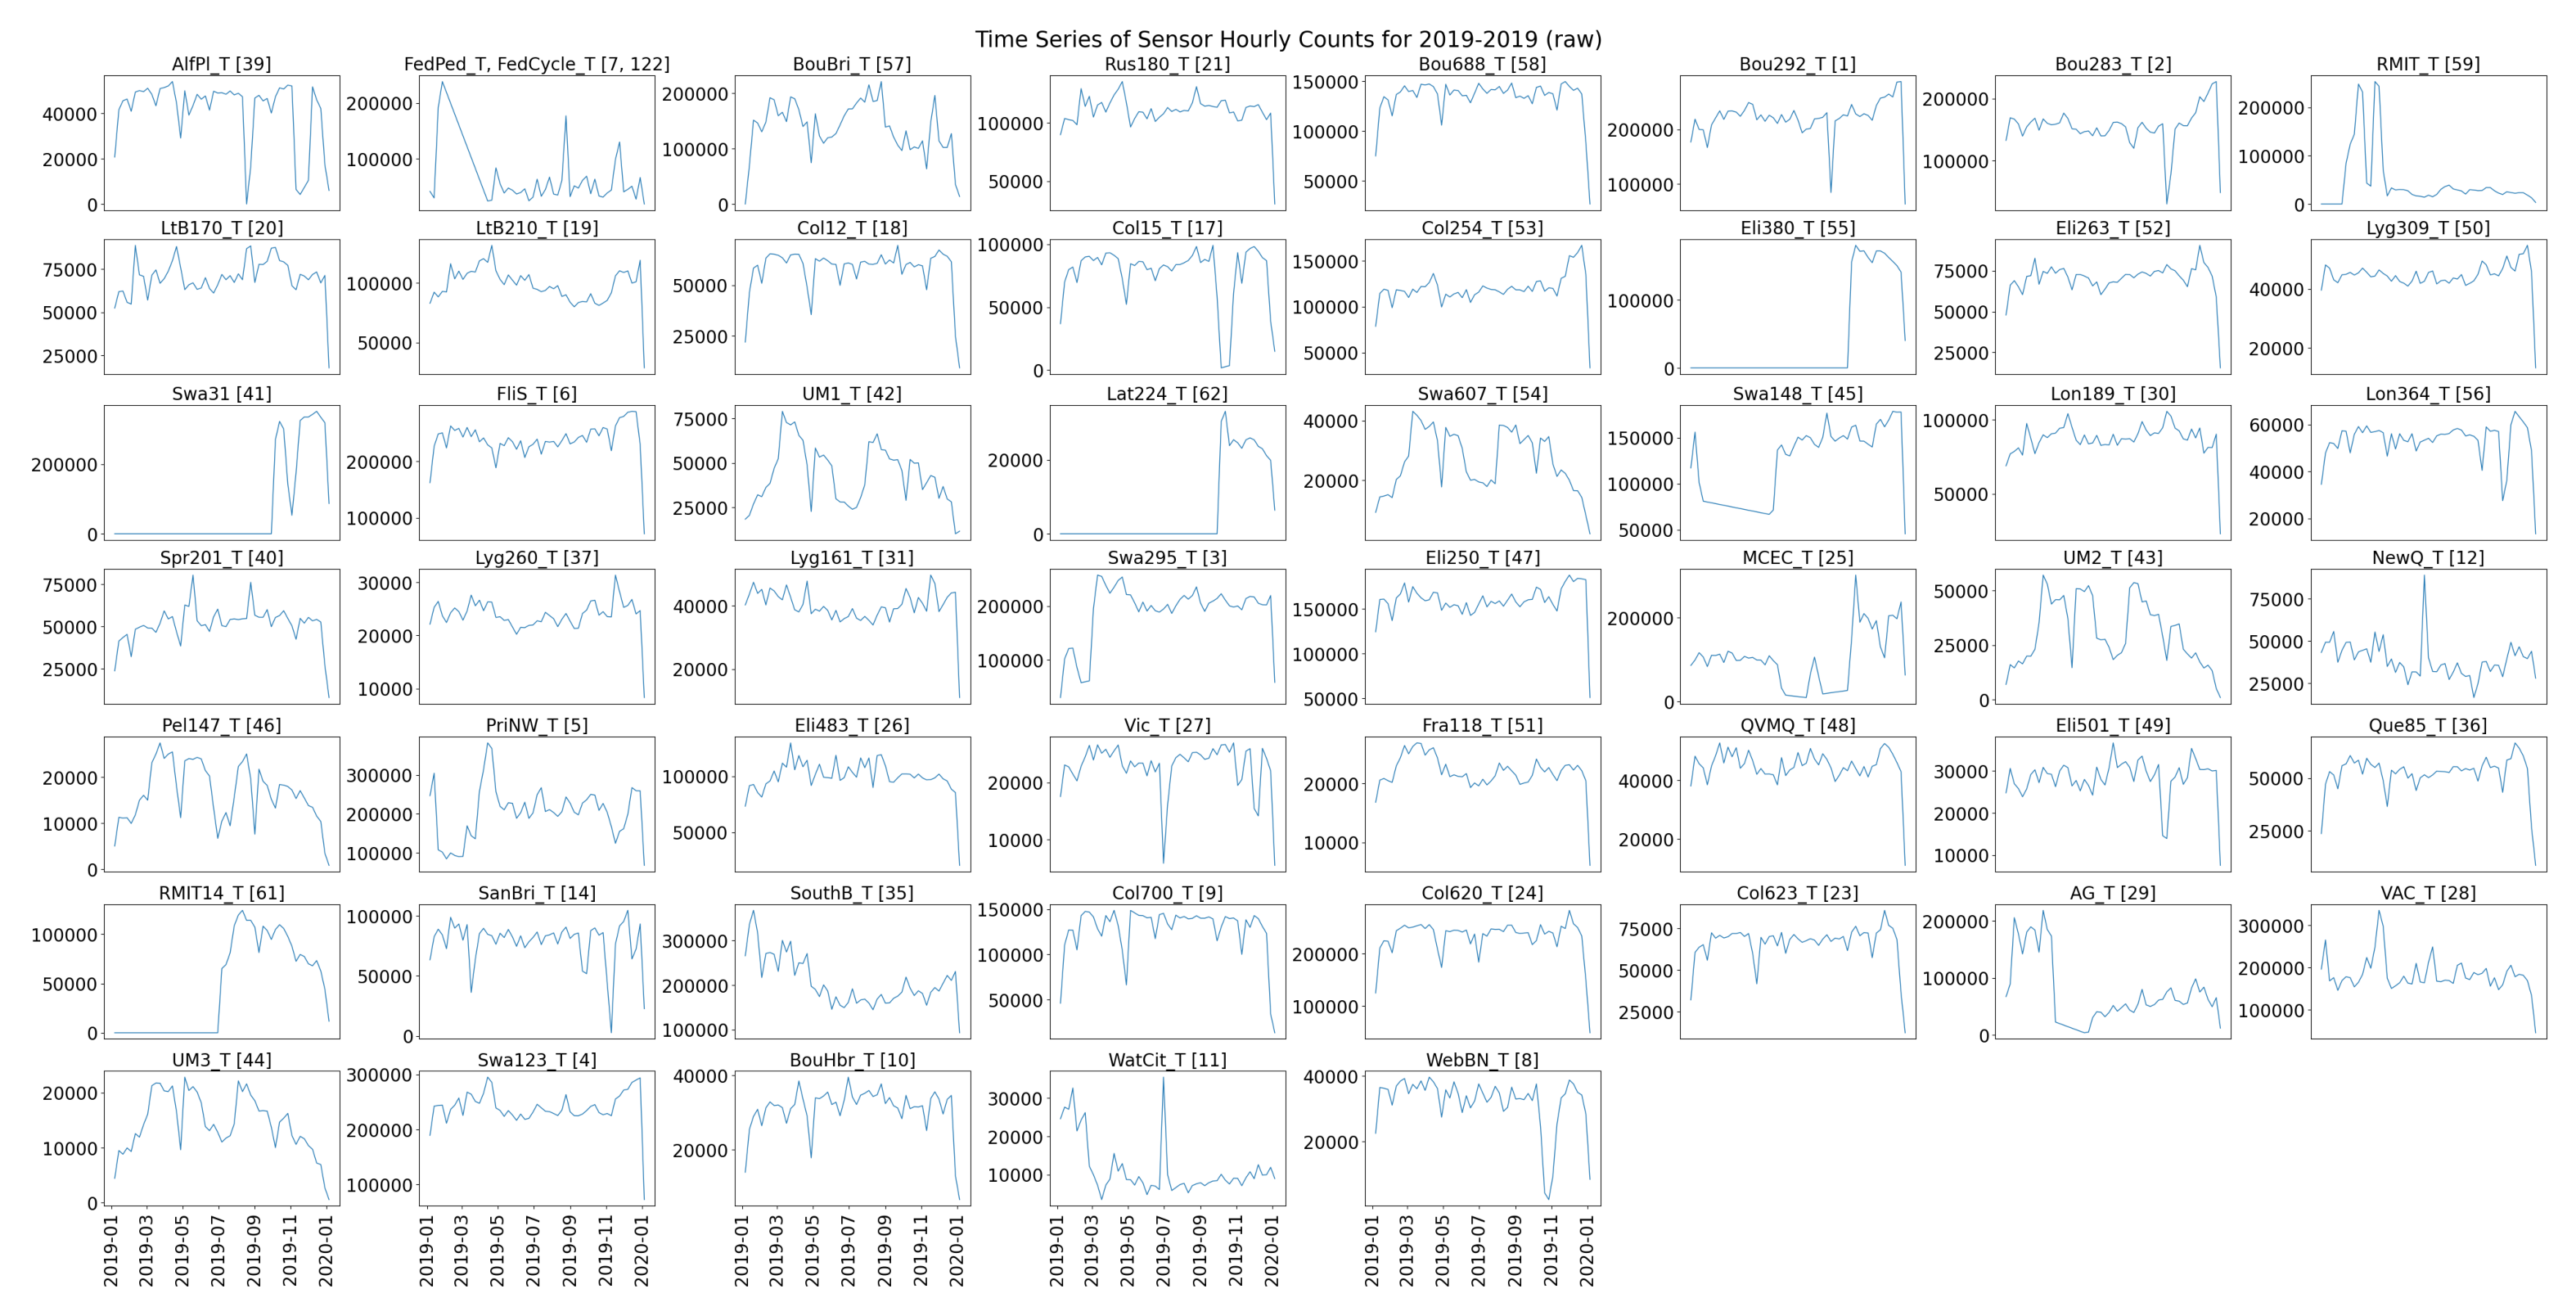

In [9]:
# pipeline.load_image(file_name='plot_imputed_data_2019_2019_raw_with_shade.png')
pipeline.load_image(file_name='plot_aggregated_data_2019_2019_raw_with_shade.png')

In [10]:
%%capture
data19_norm = pipeline.normalise_data(data19_agg)
data19_dr = pipeline.dimensionality_reduction(data19_norm)
pipeline.optimal_k()
pipeline.data_raw = data19_agg
pipeline.data_raw_norm = data19_norm
pipeline.training_each_k()

In [11]:
evaluation = pipeline.load_data(file_name=f'best_k_{pipeline.best_k[0]}/evaluation_scores.xlsx')
evaluation

Silhouette Score  Davies-Bouldin Score  Calinski-Harabasz Score
0          0.192327              1.624142                 8.969509

## <a id='toc3_2_'></a>[Impute data first then select time span](#toc0_)

In [12]:
%%capture
save_dir = Path('../../Results_impute_analysis_test2')
pipeline.set_save_dir(save_dir) # set save dir
pipeline.root_save_dir = save_dir

data_cut = pipeline.select_time_span(data=data)

data19_imputed = pipeline.impute_data(data)
data19 = pipeline.select_time_span(data19_imputed, keep_index=data_cut.index)
pipeline.plot_data(data=data19, fig_name='plot_imputed_data')

data19_agg = pipeline.aggregation(data19)
pipeline.plot_data(fig_name='plot_aggregated_data')

In [13]:
best_imputation = pipeline.load_data(file_name='best_interpolation_methods.xlsx')
best_imputation

Method        R2         MAE  \
0                linear  0.844051   78.943680   
1                  time  0.843945   78.936712   
2               slinear  0.843945   78.936712   
3               nearest  0.759732  103.665417   
4   quadratic (order 2)  0.716315   81.215517   
5       cubic (order 3)  0.694172   83.344385   
6                  zero  0.633303  135.232160   
7  polynomial (order 5) -5.382009   98.111826   
8  polynomial (order 3) -5.382009   98.111826   

                         Method Details  
0                  {'method': 'linear'}  
1                    {'method': 'time'}  
2                 {'method': 'slinear'}  
3                 {'method': 'nearest'}  
4   {'method': 'quadratic', 'order': 2}  
5       {'method': 'cubic', 'order': 3}  
6                    {'method': 'zero'}  
7  {'method': 'polynomial', 'order': 5}  
8  {'method': 'polynomial', 'order': 3}

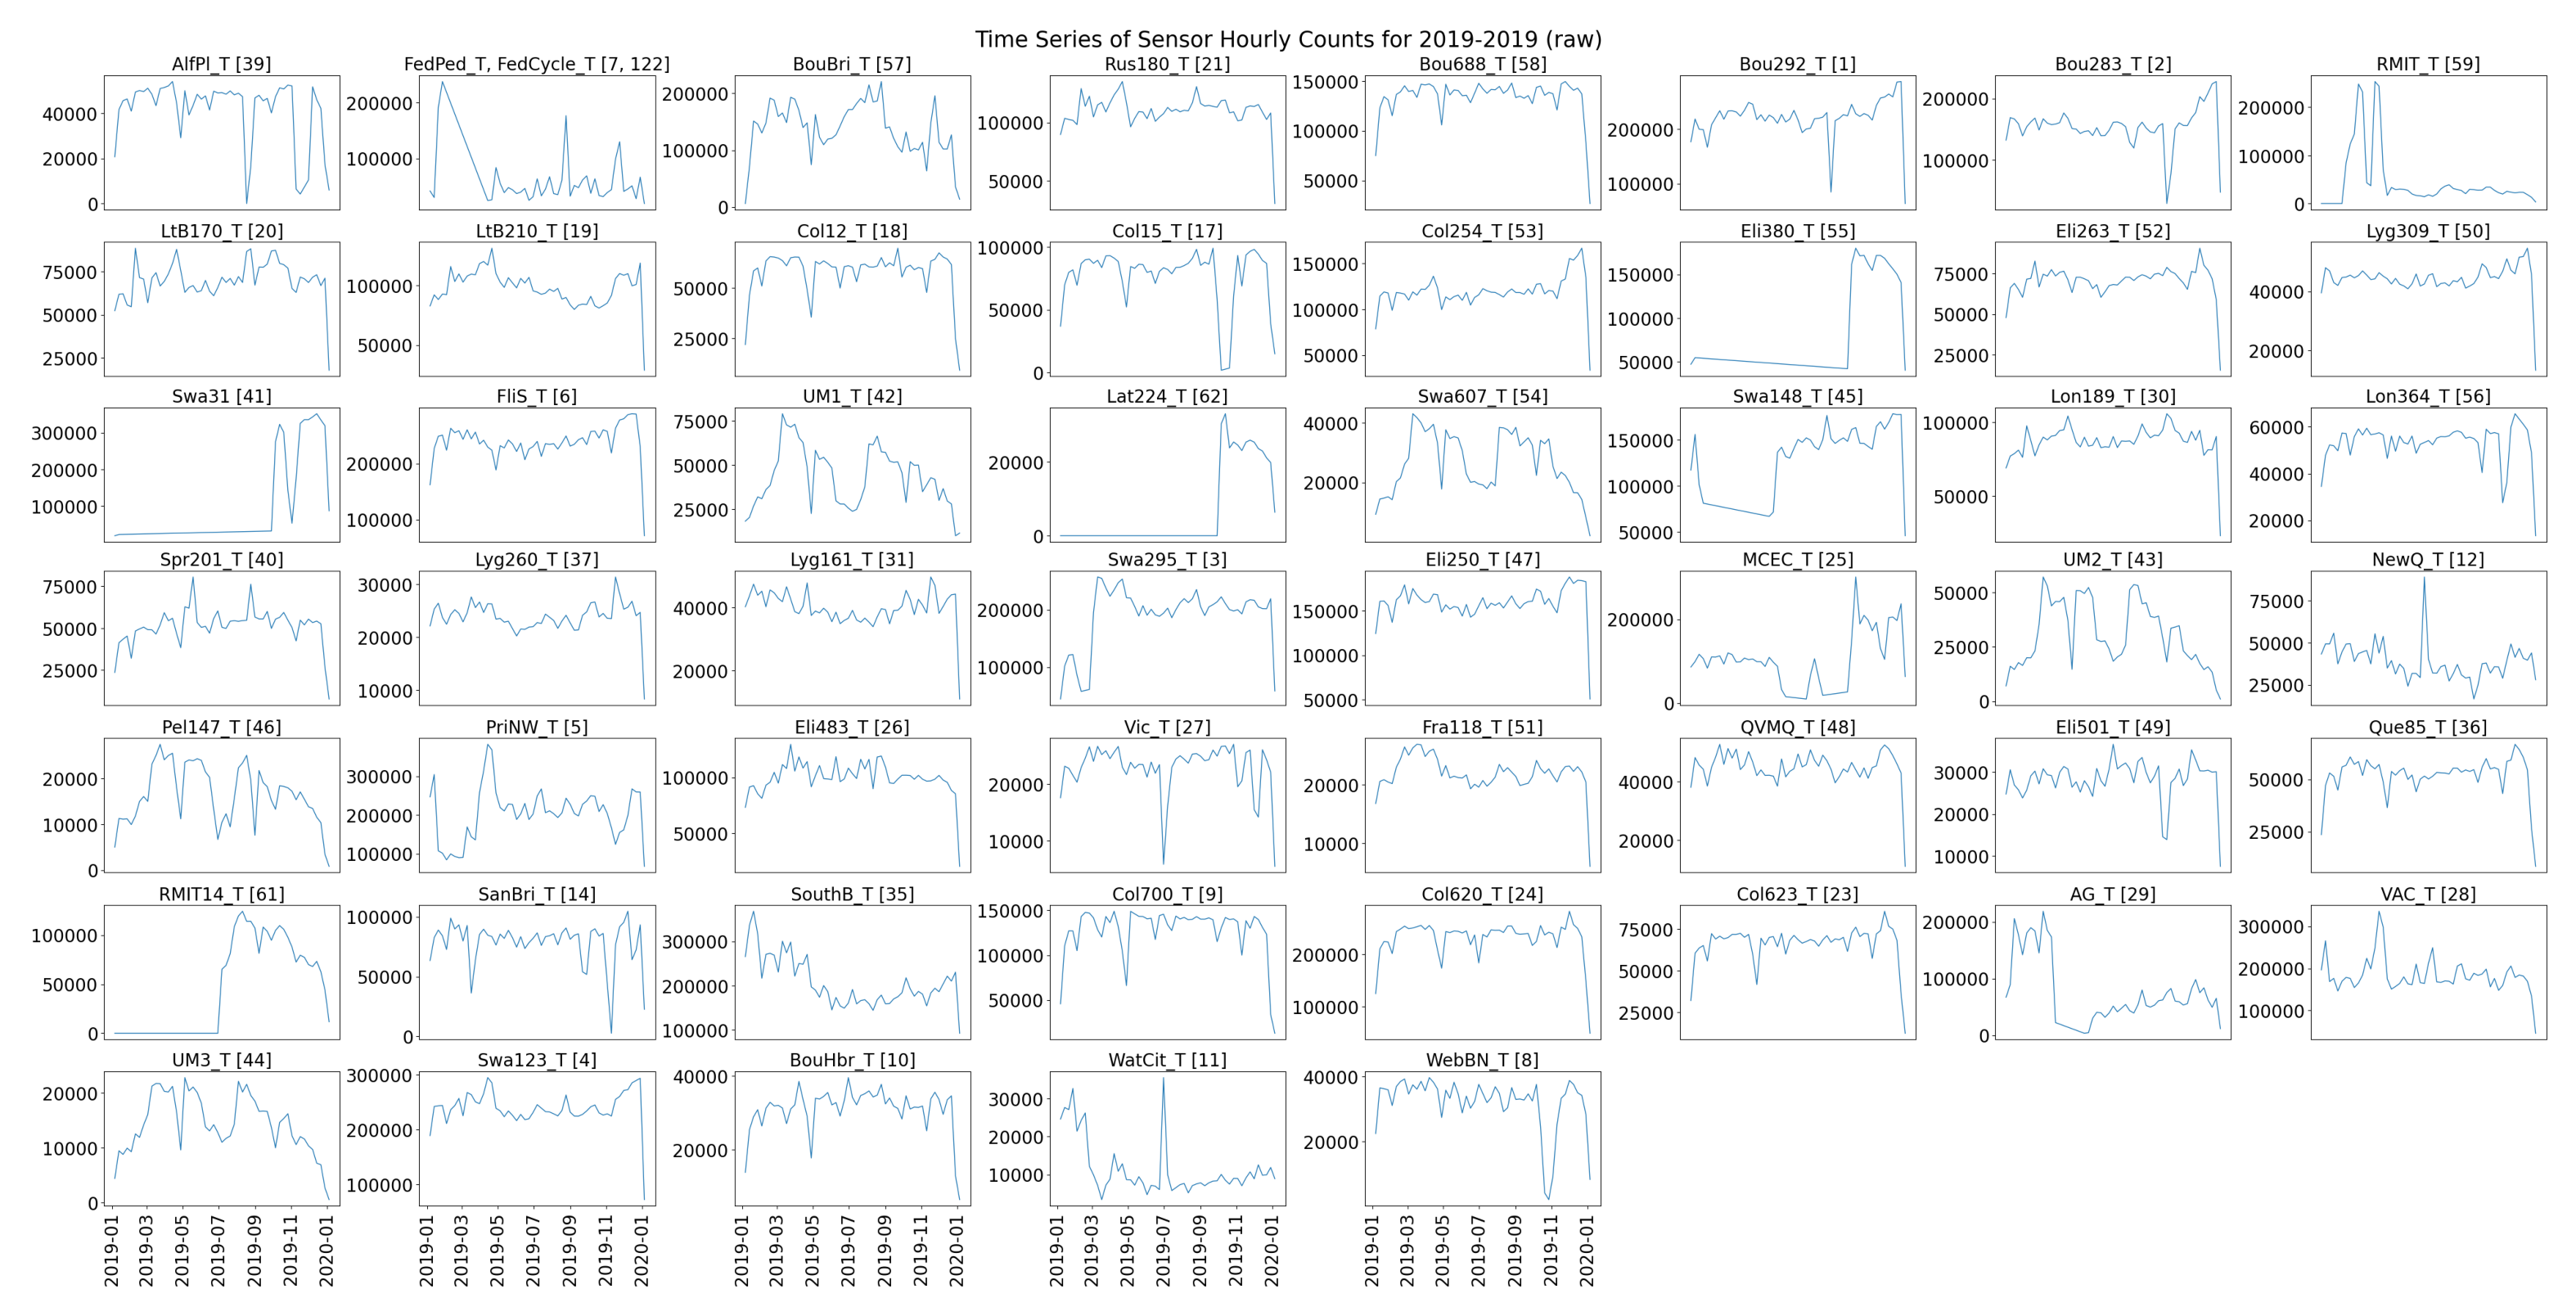

In [14]:
# pipeline.load_image(file_name='plot_imputed_data_2019_2019_raw_with_shade.png')
pipeline.load_image(file_name='plot_aggregated_data_2019_2019_raw_with_shade.png')

In [15]:
%%capture
data19_norm = pipeline.normalise_data(data19_agg)
data19_dr = pipeline.dimensionality_reduction(data19_norm)
pipeline.optimal_k()
pipeline.data_raw = data19_agg
pipeline.data_raw_norm = data19_norm
pipeline.training_each_k()

In [16]:
evaluation = pipeline.load_data(file_name=f'best_k_{pipeline.best_k[0]}/evaluation_scores.xlsx')
evaluation

Silhouette Score  Davies-Bouldin Score  Calinski-Harabasz Score
0          0.190911              1.628621                 8.868655

It appears that the sequence of actions, specifically imputation and choosing the time range, does not have a huge impact when employing a time-based imputation approach.

## <a id='toc3_3_'></a>[Remove data has big missing chunks](#toc0_)

In [17]:
%%capture
save_dir = Path('../../Results_impute_analysis_test3')
pipeline.set_save_dir(save_dir) # set save dir
pipeline.root_save_dir = save_dir

data19 = pipeline.select_time_span(data)
pipeline.plot_data(data=data19, fig_name='plot_raw_data')

data19_remove = pipeline.remove_sensors(data19)
pipeline.plot_data(fig_name='plot_filtered_data')

data19_imputed = pipeline.impute_data(data19_remove)
pipeline.plot_data(fig_name='plot_imputed_data')

data19_agg = pipeline.aggregation(data19_imputed)
pipeline.plot_data(fig_name='plot_aggregated_data')

In [18]:
best_imputation = pipeline.load_data(file_name='best_interpolation_methods.xlsx')
best_imputation

Method        R2       MAE  \
0   quadratic (order 2)  0.999085  0.938256   
1       cubic (order 3)  0.999049  0.970023   
2                  time  0.998969  0.974410   
3                linear  0.998969  0.974410   
4               slinear  0.998969  0.974410   
5  polynomial (order 5)  0.998932  1.052745   
6  polynomial (order 3)  0.998932  1.052745   
7               nearest  0.997493  1.701778   
8                  zero  0.997442  1.723635   

                         Method Details  
0   {'method': 'quadratic', 'order': 2}  
1       {'method': 'cubic', 'order': 3}  
2                    {'method': 'time'}  
3                  {'method': 'linear'}  
4                 {'method': 'slinear'}  
5  {'method': 'polynomial', 'order': 5}  
6  {'method': 'polynomial', 'order': 3}  
7                 {'method': 'nearest'}  
8                    {'method': 'zero'}

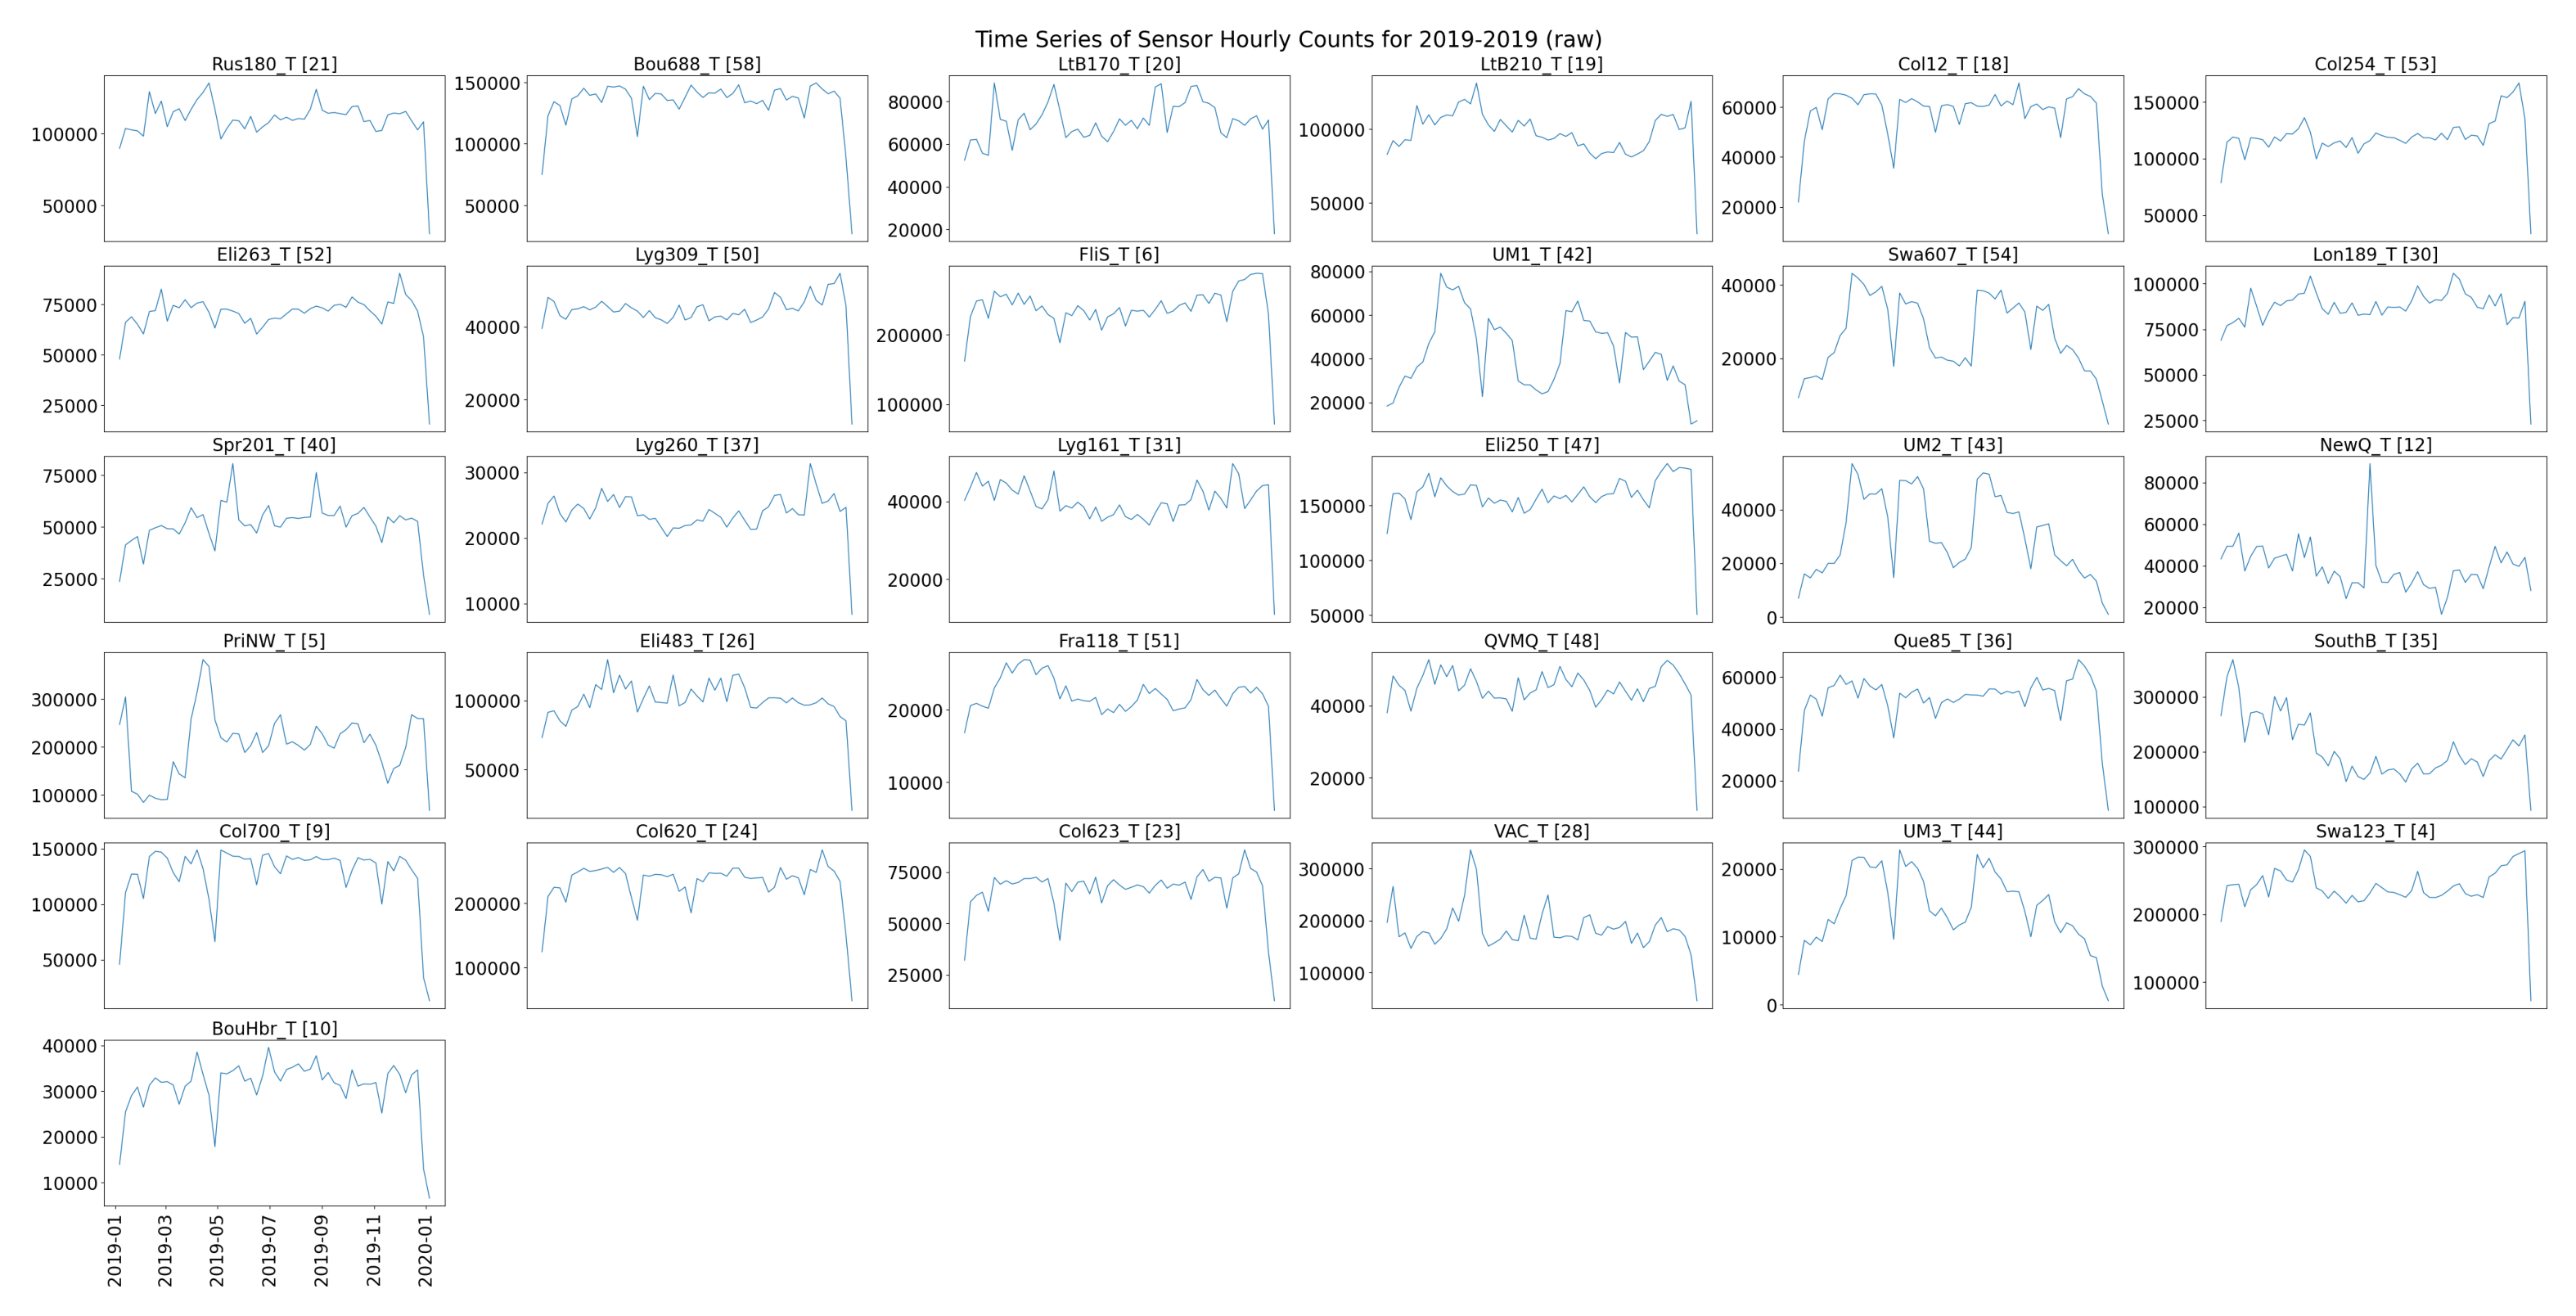

In [19]:
# pipeline.load_image(file_name='plot_imputed_data_2019_2019_raw_with_shade.png')
pipeline.load_image(file_name='plot_aggregated_data_2019_2019_raw_with_shade.png')

In [20]:
%%capture
data19_norm = pipeline.normalise_data(data19_agg)
data19_dr = pipeline.dimensionality_reduction(data19_norm)
pipeline.optimal_k()
pipeline.data_raw = data19_agg
pipeline.data_raw_norm = data19_norm
pipeline.training_each_k()

In [21]:
evaluation = pipeline.load_data(file_name=f'best_k_{pipeline.best_k[0]}/evaluation_scores.xlsx')
evaluation

Silhouette Score  Davies-Bouldin Score  Calinski-Harabasz Score
0          0.256509              1.201407                10.006481